# Semantic Surveillance: Hệ thống Giám sát An toàn Lao động Thông minh

## Tổng quan dự án

Dự án này xây dựng hệ thống giám sát việc tuân thủ trang bị bảo hộ lao động (PPE - Personal Protective Equipment) trên công trường xây dựng sử dụng Deep Learning.

### Kiến trúc kép:
- **Chế độ Sản xuất (Production)**: Sử dụng YOLOv8 đã được fine-tuned
- **Chế độ Nghiên cứu (Future)**: Sử dụng YOLO-World (Zero-shot detection)

### Quy trình End-to-End:
1. **Chuẩn bị dữ liệu** (Data Preparation)
2. **Gán nhãn** (Labeling)
3. **Trực quan hóa dữ liệu** (Data Visualization)
4. **Huấn luyện mô hình** (Model Training)
5. **Đánh giá mô hình** (Model Evaluation)
6. **Inference và Demo** (Inference & Demo)

In [1]:
# Import các thư viện cần thiết
import sys
import os
from pathlib import Path

# Thêm project root vào path
project_root = Path.cwd()
sys.path.insert(0, str(project_root))

# Core imports
from core import (
    YOLOv8Detector, 
    YOLOWorldDetector, 
    PPEChecker, 
    Visualizer,
    ViolationLogger
)
from utils import load_config, ensure_dir

# Standard libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import json
from datetime import datetime
from typing import Dict, List, Tuple
import yaml
from glob import glob
from tqdm import tqdm

# Deep Learning
from ultralytics import YOLO
import torch

print("=" * 70)
print("SEMANTIC SURVEILLANCE - END-TO-END PIPELINE")
print("=" * 70)
print(f"Project Root: {project_root}")
print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU Device: {torch.cuda.get_device_name(0)}")
print("=" * 70)

SEMANTIC SURVEILLANCE - END-TO-END PIPELINE
Project Root: c:\Workspaces\IUH\semantic_surveillance
PyTorch Version: 2.7.1+cu118
CUDA Available: True
GPU Device: NVIDIA GeForce RTX 3050 6GB Laptop GPU


## 1. Chuẩn bị Dữ liệu (Data Preparation)

### 1.1. Cấu trúc Dataset cho YOLO

Dataset cho YOLO cần có cấu trúc:
```
datasets/
└── construction-ppe/
    ├── data.yaml          # File cấu hình dataset
    ├── images/
    │   ├── train/         # Ảnh training
    │   ├── val/           # Ảnh validation
    │   └── test/          # Ảnh test (optional)
    └── labels/
        ├── train/         # Nhãn training (YOLO format)
        ├── val/           # Nhãn validation
        └── test/          # Nhãn test (optional)
```

### 1.2. Format nhãn YOLO

Mỗi file nhãn có format:
```
class_id center_x center_y width height
```
- Tọa độ được normalize về [0, 1]
- `center_x, center_y`: Tọa độ tâm bounding box
- `width, height`: Chiều rộng và chiều cao của box

In [2]:
# Kiểm tra cấu trúc dataset (nếu có)
dataset_path = project_root / "datasets" / "construction-ppe"

def check_dataset_structure(dataset_path: Path):
    """Kiểm tra cấu trúc dataset"""
    if not dataset_path.exists():
        print(f"[INFO] Dataset không tồn tại tại: {dataset_path}")
        print("[INFO] Bạn cần tạo dataset với cấu trúc YOLO format")
        return False
    
    print(f"[INFO] Kiểm tra dataset tại: {dataset_path}")
    
    # Kiểm tra data.yaml
    data_yaml = dataset_path / "data.yaml"
    if data_yaml.exists():
        print(f"Tìm thấy data.yaml")
        with open(data_yaml, 'r', encoding='utf-8') as f:
            config = yaml.safe_load(f)
            print(f"  - Số classes: {config.get('nc', 'N/A')}")
            print(f"  - Classes: {config.get('names', [])}")
    else:
        print("✗ Không tìm thấy data.yaml")
    
    # Kiểm tra thư mục images và labels
    for split in ['train', 'val', 'test']:
        img_dir = dataset_path / "images" / split
        label_dir = dataset_path / "labels" / split
        
        if img_dir.exists():
            img_count = len(list(img_dir.glob("*.*")))
            print(f"{split}/images: {img_count} files")
        else:
            print(f"{split}/images: không tồn tại")
            
        if label_dir.exists():
            label_count = len(list(label_dir.glob("*.txt")))
            print(f"{split}/labels: {label_count} files")
        else:
            print(f"{split}/labels: không tồn tại")
    
    return True

check_dataset_structure(dataset_path)

[INFO] Kiểm tra dataset tại: c:\Workspaces\IUH\semantic_surveillance\datasets\construction-ppe
Tìm thấy data.yaml
  - Số classes: N/A
  - Classes: {0: 'helmet', 1: 'gloves', 2: 'vest', 3: 'boots', 4: 'goggles', 5: 'none', 6: 'Person', 7: 'no_helmet', 8: 'no_goggle', 9: 'no_gloves', 10: 'no_boots'}
train/images: 1132 files
train/labels: 1142 files
val/images: 143 files
val/labels: 143 files
test/images: 141 files
test/labels: 141 files


True

## 2. Gán nhãn (Labeling)

### 2.1. Công cụ gán nhãn

Có thể sử dụng các công cụ:
- **LabelImg**: Công cụ phổ biến cho YOLO format
- **Roboflow**: Platform online với nhiều tính năng
- **CVAT**: Computer Vision Annotation Tool

### 2.2. Ví dụ đọc và hiển thị nhãn YOLO

In [ ]:
def read_yolo_label(label_path: Path, img_width: int, img_height: int) -> List[Dict]:
    """
    Đọc file nhãn YOLO và chuyển đổi về tọa độ pixel.
    
    Args:
        label_path: Đường dẫn file .txt
        img_width: Chiều rộng ảnh
        img_height: Chiều cao ảnh
    
    Returns:
        List các detection với format: [class_id, x1, y1, x2, y2]
    """
    detections = []
    
    if not label_path.exists():
        return detections
    
    with open(label_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) != 5:
                continue
            
            class_id = int(parts[0])
            center_x = float(parts[1]) * img_width
            center_y = float(parts[2]) * img_height
            width = float(parts[3]) * img_width
            height = float(parts[4]) * img_height
            
            # Chuyển đổi về format [x1, y1, x2, y2]
            x1 = center_x - width / 2
            y1 = center_y - height / 2
            x2 = center_x + width / 2
            y2 = center_y + height / 2
            
            detections.append({
                'class_id': class_id,
                'bbox': [x1, y1, x2, y2]
            })
    
    return detections


def visualize_yolo_labels(img_path: Path, label_path: Path, class_names: List[str] = None):
    """
    Hiển thị ảnh với các bounding box từ nhãn YOLO.
    
    Args:
        img_path: Đường dẫn ảnh
        label_path: Đường dẫn file nhãn
        class_names: Danh sách tên classes (optional)
    """
    img = cv2.imread(str(img_path))
    if img is None:
        print(f"Không thể đọc ảnh: {img_path}")
        return None
    
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]
    
    detections = read_yolo_label(label_path, w, h)
    
    # Vẽ bounding boxes
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    ax.imshow(img_rgb)
    
    colors = plt.cm.tab10(np.linspace(0, 1, 10))
    
    for det in detections:
        class_id = det['class_id']
        x1, y1, x2, y2 = det['bbox']
        
        color = colors[class_id % len(colors)]
        rect = Rectangle((x1, y1), x2-x1, y2-y1, 
                        linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(rect)
        
        label = class_names[class_id] if class_names and class_id < len(class_names) else f"Class {class_id}"
        ax.text(x1, y1-5, label, color=color, fontsize=10, weight='bold')
    
    ax.axis('off')
    plt.tight_layout()
    return fig
print("[INFO] Hàm visualize_yolo_labels đã sẵn sàng")

[INFO] Hàm visualize_yolo_labels đã sẵn sàng


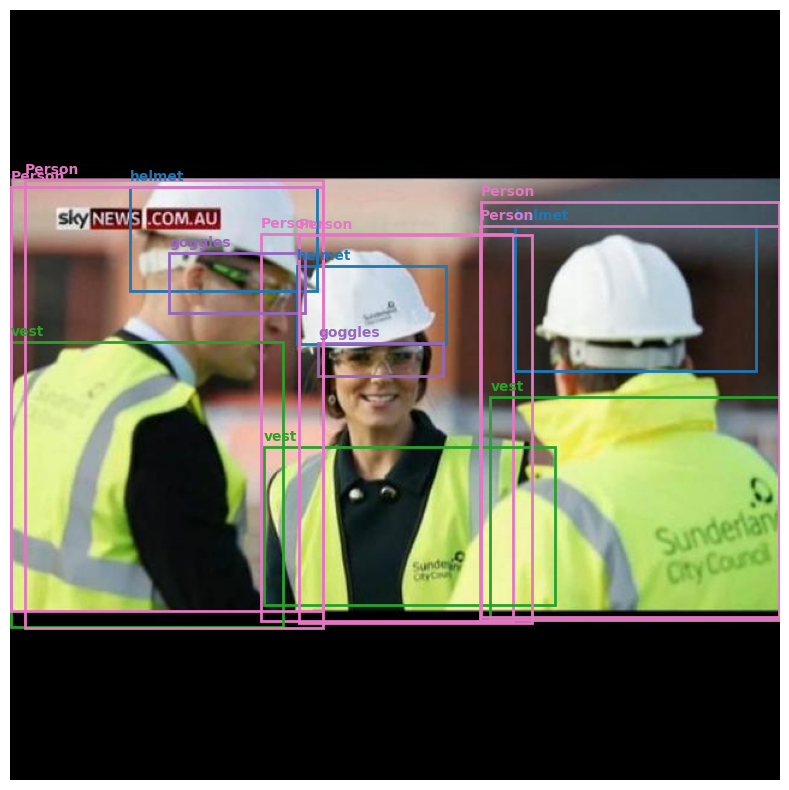

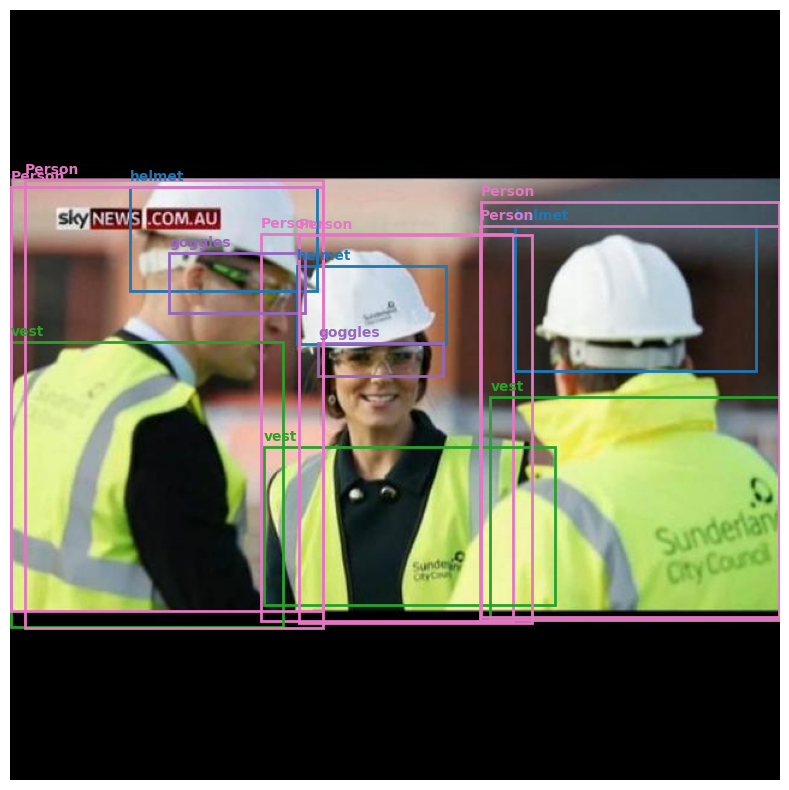

In [10]:
# Ví dụ sử dụng (nếu có dataset)
img_path = dataset_path / "images" / "train" / "image2.jpg"
label_path = dataset_path / "labels" / "train" / "image2.txt"
class_names = ['helmet','gloves', 'vest', 'boots', 'goggles', 'none', 'Person', 'no_helmet', 'no_goggle', 'no_gloves', 'no_boots']
visualize_yolo_labels(img_path, label_path, class_names)

## 3. Trực quan hóa Dữ liệu (Data Visualization)

### 3.1. Phân tích phân phối classes

In [13]:
def analyze_dataset_statistics(dataset_path: Path, split: str = 'train'):
    """
    Phân tích thống kê dataset.
    
    Args:
        dataset_path: Đường dẫn dataset
        split: 'train', 'val', hoặc 'test'
    
    Returns:
        Dictionary chứa thống kê
    """
    label_dir = dataset_path / "labels" / split
    
    if not label_dir.exists():
        print(f"[WARNING] Không tìm thấy {label_dir}")
        return None
    
    class_counts = {}
    total_images = 0
    total_objects = 0
    
    label_files = list(label_dir.glob("*.txt"))
    
    for label_file in label_files:
        total_images += 1
        with open(label_file, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) == 5:
                    class_id = int(parts[0])
                    class_counts[class_id] = class_counts.get(class_id, 0) + 1
                    total_objects += 1
    
    stats = {
        'total_images': total_images,
        'total_objects': total_objects,
        'class_counts': class_counts,
        'avg_objects_per_image': total_objects / total_images if total_images > 0 else 0
    }
    
    return stats


def plot_dataset_statistics(stats: Dict, class_names: List[str] = None):
    """Vẽ biểu đồ thống kê dataset"""
    if stats is None:
        print("[WARNING] Không có dữ liệu để vẽ")
        return
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Biểu đồ phân phối classes
    classes = sorted(stats['class_counts'].keys())
    counts = [stats['class_counts'][c] for c in classes]
    labels = [class_names[c] if class_names and c < len(class_names) else f"Class {c}" 
              for c in classes]
    
    axes[0].bar(labels, counts, color=plt.cm.tab10(np.linspace(0, 1, len(classes))))
    axes[0].set_xlabel('Class')
    axes[0].set_ylabel('So luong')
    axes[0].set_title(f'Phan phoi Classes\n(Tổng: {stats["total_objects"]} objects)')
    axes[0].tick_params(axis='x', rotation=45)
    axes[0].grid(axis='y', alpha=0.3)
    
    # Thông tin tổng quan
    info_text = f"""
    Tong so anh: {stats['total_images']}
    Tong so object trong anh: {stats['total_objects']}
    Trung binh objects/anh: {stats['avg_objects_per_image']:.2f}
    """
    axes[1].text(0.1, 0.5, info_text, fontsize=12, 
                 verticalalignment='center', family='monospace')
    axes[1].axis('off')
    axes[1].set_title('Thong ke datasets')
    
    plt.tight_layout()
    return fig
print("[INFO] Hàm phân tích dataset đã sẵn sàng")

[INFO] Hàm phân tích dataset đã sẵn sàng


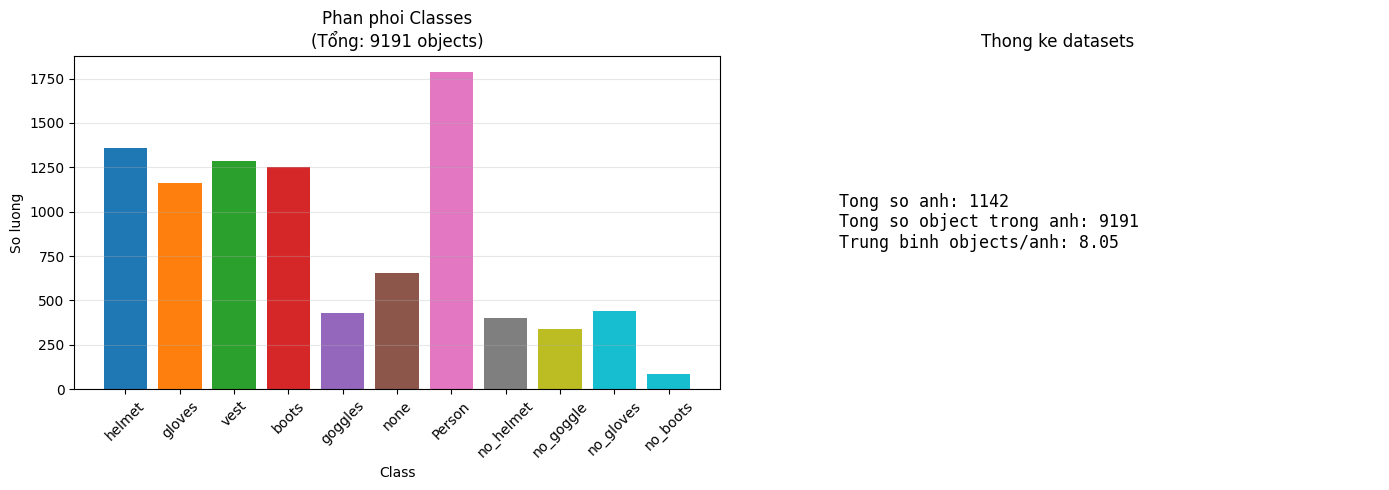

In [14]:
# Ví dụ sử dụng (nếu có dataset)
stats = analyze_dataset_statistics(dataset_path, 'train')
if stats:
    class_names = ['helmet','gloves', 'vest', 'boots', 'goggles', 'none', 'Person', 'no_helmet', 'no_goggle', 'no_gloves', 'no_boots']
    plot_dataset_statistics(stats, class_names)

## 4. Huấn luyện Mô hình (Model Training)

### 4.1. Kiểm tra GPU và thiết lập môi trường

In [15]:
# Kiểm tra GPU
cuda_available = torch.cuda.is_available()
print("=" * 70)
print("KIỂM TRA MÔI TRƯỜNG HUẤN LUYỆN")
print("=" * 70)
print(f"GPU Available: {cuda_available}")

if cuda_available:
    device = 0
    print(f"GPU Device: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
    print(f"Training sẽ sử dụng: GPU")
    recommended_batch = 16
    recommended_epochs = 50
else:
    device = 'cpu'
    print("GPU không khả dụng - training trên CPU (sẽ CHẬM!)")
    print("Tip: Cài đặt PyTorch với CUDA support để training nhanh hơn")
    recommended_batch = 8
    recommended_epochs = 20

print(f"Recommended batch size: {recommended_batch}")
print(f"Recommended epochs: {recommended_epochs}")
print("=" * 70)

KIỂM TRA MÔI TRƯỜNG HUẤN LUYỆN
GPU Available: True
GPU Device: NVIDIA GeForce RTX 3050 6GB Laptop GPU
GPU Memory: 6.00 GB
Training sẽ sử dụng: GPU
Recommended batch size: 16
Recommended epochs: 50


### 4.2. Khởi tạo mô hình YOLOv8

In [17]:
def initialize_yolo_model(model_size: str = 'n', pretrained: bool = True):
    """
    Khởi tạo mô hình YOLOv8.
    
    Args:
        model_size: 'n' (nano), 's' (small), 'm' (medium), 'l' (large), 'x' (xlarge)
        pretrained: Sử dụng pretrained weights hay không
    
    Returns:
        YOLO model object
    """
    if pretrained:
        model_name = f'yolov8{model_size}.pt'
        print(f"[INFO] Loading pretrained model: {model_name}")
        model = YOLO(model_name)
    else:
        # Tạo mô hình từ đầu (không khuyến nghị)
        print(f"[INFO] Creating YOLOv8{model_size} from scratch")
        model = YOLO(f'yolov8{model_size}.yaml')
    
    return model


# Khởi tạo mô hình (ví dụ)
print("[INFO] Khởi tạo mô hình YOLOv8n...")
try:
    model = initialize_yolo_model(model_size='n', pretrained=True)
    print("Mô hình đã được khởi tạo thành công")
except Exception as e:
    print(f"Lỗi khi khởi tạo mô hình: {e}")
    print("[INFO] Bạn có thể cần tải pretrained weights từ Ultralytics")

[INFO] Khởi tạo mô hình YOLOv8n...
[INFO] Loading pretrained model: yolov8n.pt
Mô hình đã được khởi tạo thành công


### 4.3. Huấn luyện mô hình

**Lưu ý**: Cell này sẽ thực sự training mô hình. Chỉ chạy khi đã có dataset đầy đủ.

In [ ]:
def train_ppe_model(
    model,
    data_yaml_path: str,
    epochs: int = 50,
    imgsz: int = 640,
    batch: int = 16,
    device: str = 0,
    project: str = 'runs/detect',
    name: str = 'ppe_detector'
):
    """
    Huấn luyện mô hình YOLOv8 trên dataset PPE.
    
    Args:
        model: YOLO model object
        data_yaml_path: Đường dẫn file data.yaml
        epochs: Số epochs
        imgsz: Kích thước ảnh input
        batch: Batch size
        device: Device (0 cho GPU, 'cpu' cho CPU)
        project: Thư mục project
        name: Tên thư mục kết quả
    
    Returns:
        Training results
    """
    print("=" * 70)
    print("BẮT ĐẦU HUẤN LUYỆN MÔ HÌNH")
    print("=" * 70)
    print(f"Dataset: {data_yaml_path}")
    print(f"Epochs: {epochs}")
    print(f"Image size: {imgsz}")
    print(f"Batch size: {batch}")
    print(f"Device: {device}")
    print("=" * 70)
    
    try:
        results = model.train(
            data=data_yaml_path,
            epochs=epochs,
            imgsz=imgsz,
            batch=batch,
            name=name,
            patience=15,  # Early stopping
            device=device,
            workers=0,  # 0 cho Windows để tránh multiprocessing issues
            plots=True,  # Tạo plots
            save=True,  # Lưu checkpoints
            val=True,  # Validation trong quá trình training
            cache=False,  # Không cache images (tiết kiệm RAM)
            project=project,
            exist_ok=True,
            verbose=True
        )
        
        print("\n" + "=" * 70)
        print("HUẤN LUYỆN HOÀN TẤT!")
        print("=" * 70)
        
        # Validation
        print("\n[INFO] Chạy validation...")
        metrics = model.val()
        
        print(f"\nBest model saved to: {project}/{name}/weights/best.pt")
        print(f"\nMetrics:")
        print(f"  mAP50: {metrics.box.map50:.3f}")
        print(f"  mAP50-95: {metrics.box.map:.3f}")
        print("=" * 70)
        
        return results, metrics
        
    except Exception as e:
        print(f"\nHUẤN LUYỆN THẤT BẠI: {e}")
        print("Kiểm tra đường dẫn dataset và format")
        raise
print("[INFO] Hàm train_ppe_model đã sẵn sàng")

[INFO] Hàm train_ppe_model đã sẵn sàng


In [19]:
# Ví dụ sử dụng (UNCOMMENT để chạy training thực sự)
data_yaml = "datasets/construction-ppe/data.yaml"
if os.path.exists(data_yaml):
    results, metrics = train_ppe_model(
        model=model,
        data_yaml_path=data_yaml,
        epochs=recommended_epochs,
        batch=recommended_batch,
        device=device
    )
else:
    print(f"[INFO] Dataset không tồn tại tại: {data_yaml}")
    print("[INFO] Bỏ qua bước training")

BẮT ĐẦU HUẤN LUYỆN MÔ HÌNH
Dataset: datasets/construction-ppe/data.yaml
Epochs: 50
Image size: 640
Batch size: 16
Device: 0
New https://pypi.org/project/ultralytics/8.4.7 available  Update with 'pip install -U ultralytics'
Ultralytics 8.4.6  Python-3.11.14 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3050 6GB Laptop GPU, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=datasets/construction-ppe/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0

## 5. Đánh giá Mô hình (Model Evaluation)

### 5.1. Load mô hình đã train và đánh giá

In [25]:
def load_trained_model(model_path: str):
    """
    Load mô hình đã được train.
    
    Args:
        model_path: Đường dẫn file .pt
    
    Returns:
        YOLO model object
    """
    if not os.path.exists(model_path):
        print(f"[WARNING] Không tìm thấy mô hình tại: {model_path}")
        return None
    
    print(f"[INFO] Loading trained model: {model_path}")
    model = YOLO(model_path)
    return model


def evaluate_model(model, data_yaml_path: str):
    """
    Đánh giá mô hình trên validation set.
    
    Args:
        model: YOLO model object
        data_yaml_path: Đường dẫn file data.yaml
    
    Returns:
        Metrics dictionary
    """
    print("[INFO] Đang đánh giá mô hình...")
    metrics = model.val(data=data_yaml_path)
    
    print("\n" + "=" * 70)
    print("KẾT QUẢ ĐÁNH GIÁ")
    print("=" * 70)
    print(f"mAP50: {metrics.box.map50:.4f}")
    print(f"mAP50-95: {metrics.box.map:.4f}")
    print(f"Precision: {metrics.box.mp:.4f}")
    print(f"Recall: {metrics.box.mr:.4f}")
    print("=" * 70)
    
    return metrics


# Kiểm tra mô hình đã train
# trained_model_path = project_root / "weights" / "yolo8s_ppedetect_50e_best.pt"
trained_model_path = project_root /"runs"/"detect"/"runs"/"detect"/"ppe_detector"/"weights"/"best.pt"

if trained_model_path.exists():
    print(f"[INFO] Tìm thấy mô hình đã train: {trained_model_path}")
    trained_model = load_trained_model(str(trained_model_path))
    
    # Đánh giá nếu có dataset
    data_yaml = "datasets/construction-ppe/data.yaml"
    if os.path.exists(data_yaml):
        metrics = evaluate_model(trained_model, data_yaml)
else:
    print(f"[INFO] Chưa có mô hình đã train tại: {trained_model_path}")
    print("[INFO] Bạn cần train mô hình trước")

[INFO] Tìm thấy mô hình đã train: c:\Workspaces\IUH\semantic_surveillance\runs\detect\runs\detect\ppe_detector\weights\best.pt
[INFO] Loading trained model: c:\Workspaces\IUH\semantic_surveillance\runs\detect\runs\detect\ppe_detector\weights\best.pt
[INFO] Đang đánh giá mô hình...
Ultralytics 8.4.6  Python-3.11.14 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3050 6GB Laptop GPU, 6144MiB)
Model summary (fused): 73 layers, 3,007,793 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 1238.3491.9 MB/s, size: 101.0 KB)
val: Scanning C:\Workspaces\IUH\semantic_surveillance\datasets\construction-ppe\labels\val.cache... 143 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 143/143  0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.9it/s 1.8s0.2ss
                   all        143       1172       0.65      0.519      0.543      0.267
                helmet        107        201      0.765   

## 6. Inference và Demo

### 6.1. Sử dụng mô hình đã train (Production Mode - YOLOv8)

In [26]:
# Load config cho Production mode
config_prod_path = project_root / "config" / "config_yolov8_production.yaml"

if config_prod_path.exists():
    config_prod = load_config(str(config_prod_path))
    print("[INFO] Đã load config Production")
    print(f"  - Model path: {config_prod['detection']['model_path']}")
    print(f"  - Confidence threshold: {config_prod['detection']['confidence_threshold']}")
    print(f"  - Required equipment: {config_prod['ppe_rules']['required_equipment']}")
else:
    print(f"[WARNING] Không tìm thấy config: {config_prod_path}")
    config_prod = None

[INFO] Đã load config Production
  - Model path: weights/yolo8s_ppedetect_50e_best.pt
  - Confidence threshold: 0.5
  - Required equipment: ['hard_hat', 'safety_vest']


In [27]:
def demo_inference_on_image(
    image_path: str,
    config_path: str = None,
    save_output: bool = True
):
    """
    Chạy inference trên một ảnh.
    
    Args:
        image_path: Đường dẫn ảnh
        config_path: Đường dẫn config file (optional)
        save_output: Có lưu kết quả hay không
    
    Returns:
        Annotated image
    """
    # Load config
    if config_path is None:
        config_path = str(config_prod_path)
    
    config = load_config(config_path)
    
    # Khởi tạo detector
    detection_type = config.get('detection', {}).get('type', 'trained')
    
    if detection_type == 'trained':
        model_path = config['detection']['model_path']
        detector = YOLOv8Detector(model_path=model_path, config=config)
        print(f"[INFO] Sử dụng YOLOv8Detector (Production)")
    else:
        model_size = config['detection'].get('model_size', 's')
        model_path = f'weights/yolov8{model_size}-world.pt'
        detector = YOLOWorldDetector(model_path=model_path, config=config)
        prompts = config['ppe_rules'].get('prompts', [])
        detector.set_prompts(prompts)
        print(f"[INFO] Sử dụng YOLOWorldDetector (Zero-shot)")
    
    # Khởi tạo checker và visualizer
    checker = PPEChecker(config)
    visualizer = Visualizer(config)
    
    # Đọc ảnh
    frame = cv2.imread(image_path)
    if frame is None:
        print(f"[ERROR] Không thể đọc ảnh: {image_path}")
        return None
    
    print(f"[INFO] Processing image: {image_path}")
    
    # 1. Detection
    results = detector.predict(
        frame,
        conf_threshold=config['detection']['confidence_threshold'],
        iou_threshold=config['detection'].get('iou_threshold', 0.45)
    )
    
    # 2. Parse detections
    detections = detector.get_detections(results)
    persons = detections.get('person', [])
    equipment = {k: v for k, v in detections.items() if k != 'person'}
    
    print(f"  - Detected {len(persons)} persons")
    for eq_name, boxes in equipment.items():
        print(f"  - Detected {len(boxes)} {eq_name}")
    
    # 3. Check compliance
    compliance_results = checker.check_compliance(persons, equipment)
    
    violations = sum(1 for r in compliance_results if not r.is_compliant)
    print(f"  - Violations: {violations}/{len(compliance_results)}")
    
    # 4. Visualize
    annotated_frame = visualizer.draw_results(frame, compliance_results, equipment)
    
    # 5. Save nếu cần
    if save_output:
        output_path = project_root / "output" / f"demo_{Path(image_path).name}"
        ensure_dir(output_path.parent)
        cv2.imwrite(str(output_path), annotated_frame)
        print(f"[INFO] Đã lưu kết quả: {output_path}")
    
    return annotated_frame


print("[INFO] Hàm demo_inference_on_image đã sẵn sàng")

[INFO] Hàm demo_inference_on_image đã sẵn sàng


### 6.2. Demo trên ảnh mẫu

[INFO] Tìm thấy 8 ảnh demo

[INFO] Demo trên ảnh: 2.jpg
[INFO] Loading model: weights/yolo8s_ppedetect_50e_best.pt
[INFO] Detector Mode: YOLOv8 (Trained/Production)
[INFO] Sử dụng YOLOv8Detector (Production)
[INFO] Processing image: c:\Workspaces\IUH\semantic_surveillance\output\demo_yoloworld\2.jpg
  - Detected 1 persons
  - Detected 1 hard_hat
  - Detected 1 safety_vest
  - Detected 0 safety_boots
  - Detected 0 gloves
  - Detected 0 safety_goggles
  - Violations: 0/1
[INFO] Đã lưu kết quả: c:\Workspaces\IUH\semantic_surveillance\output\demo_2.jpg


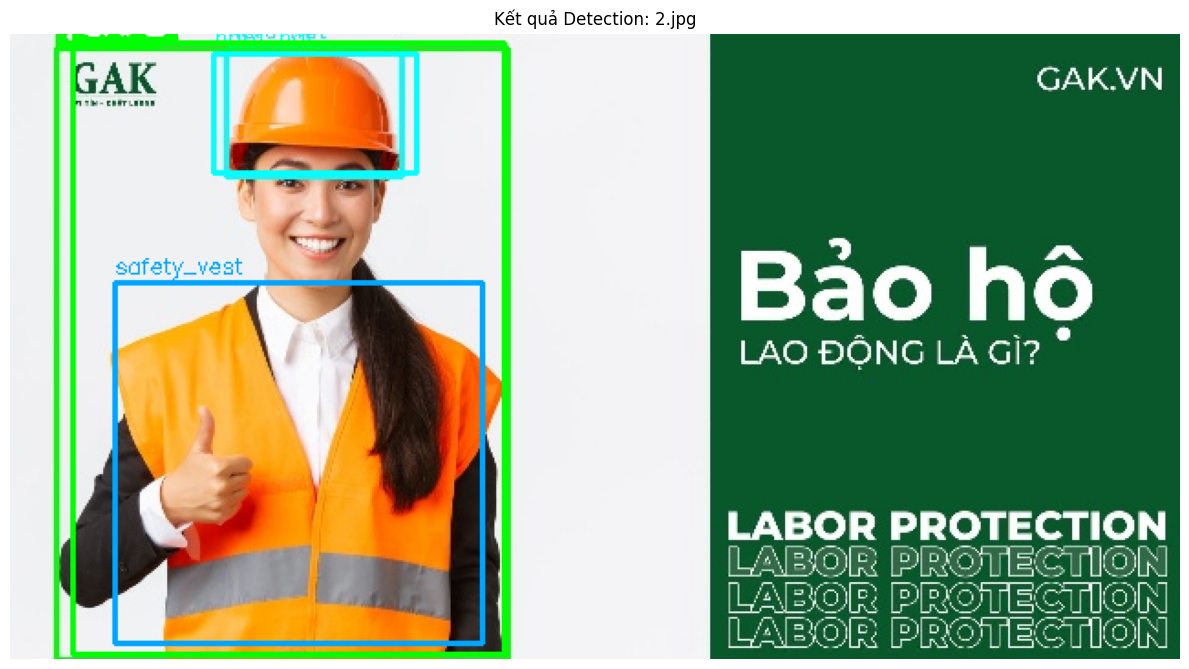

In [28]:
# Tìm ảnh mẫu trong output/demo_yoloworld (nếu có)
demo_images_dir = project_root / "output" / "demo_yoloworld"

if demo_images_dir.exists():
    demo_images = list(demo_images_dir.glob("*.jpg")) + list(demo_images_dir.glob("*.png"))
    if demo_images:
        print(f"[INFO] Tìm thấy {len(demo_images)} ảnh demo")
        
        # Chọn ảnh đầu tiên để demo
        sample_image = demo_images[0]
        print(f"\n[INFO] Demo trên ảnh: {sample_image.name}")
        
        # Chạy inference
        try:
            result = demo_inference_on_image(
                str(sample_image),
                config_path=str(config_prod_path) if config_prod_path.exists() else None,
                save_output=True
            )
            
            if result is not None:
                # Hiển thị kết quả
                result_rgb = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
                plt.figure(figsize=(12, 8))
                plt.imshow(result_rgb)
                plt.axis('off')
                plt.title(f'Kết quả Detection: {sample_image.name}')
                plt.tight_layout()
                plt.show()
        except Exception as e:
            print(f"[ERROR] Lỗi khi chạy inference: {e}")
    else:
        print("[INFO] Không tìm thấy ảnh demo trong output/demo_yoloworld")
else:
    print("[INFO] Thư mục demo không tồn tại")
    print("[INFO] Bạn có thể test với ảnh của mình bằng cách:")
    print("  result = demo_inference_on_image('path/to/your/image.jpg')")

### 6.3. So sánh YOLOv8 (Trained) vs YOLO-World (Zero-shot)

In [29]:
def compare_models_on_image(image_path: str):
    """
    So sánh kết quả của YOLOv8 (trained) và YOLO-World (zero-shot) trên cùng một ảnh.
    
    Args:
        image_path: Đường dẫn ảnh
    
    Returns:
        Tuple (result_yolov8, result_yoloworld)
    """
    frame = cv2.imread(image_path)
    if frame is None:
        print(f"[ERROR] Không thể đọc ảnh: {image_path}")
        return None, None
    
    # Load configs
    config_prod = load_config(str(project_root / "config" / "config_yolov8_production.yaml"))
    config_future = load_config(str(project_root / "config" / "config_yoloworld_future.yaml"))
    
    results = {}
    
    # 1. YOLOv8 (Production)
    print("\n[INFO] Chạy YOLOv8 (Trained)...")
    try:
        detector_prod = YOLOv8Detector(
            model_path=config_prod['detection']['model_path'],
            config=config_prod
        )
        checker_prod = PPEChecker(config_prod)
        visualizer_prod = Visualizer(config_prod)
        
        results_prod = detector_prod.predict(
            frame,
            conf_threshold=config_prod['detection']['confidence_threshold'],
            iou_threshold=config_prod['detection'].get('iou_threshold', 0.45)
        )
        detections_prod = detector_prod.get_detections(results_prod)
        persons_prod = detections_prod.get('person', [])
        equipment_prod = {k: v for k, v in detections_prod.items() if k != 'person'}
        compliance_prod = checker_prod.check_compliance(persons_prod, equipment_prod)
        result_prod = visualizer_prod.draw_results(frame.copy(), compliance_prod, equipment_prod)
        results['yolov8'] = result_prod
        print(f"Detected {len(persons_prod)} persons, {sum(len(v) for v in equipment_prod.values())} equipment")
    except Exception as e:
        print(f"Lỗi: {e}")
        results['yolov8'] = None
    
    # 2. YOLO-World (Zero-shot)
    print("\n[INFO] Chạy YOLO-World (Zero-shot)...")
    try:
        model_size = config_future['detection'].get('model_size', 's')
        model_path = f'weights/yolov8{model_size}-world.pt'
        detector_future = YOLOWorldDetector(model_path=model_path, config=config_future)
        prompts = config_future['ppe_rules'].get('prompts', [])
        detector_future.set_prompts(prompts)
        
        checker_future = PPEChecker(config_future)
        visualizer_future = Visualizer(config_future)
        
        results_future = detector_future.predict(
            frame,
            conf_threshold=config_future['detection']['confidence_threshold'],
            iou_threshold=config_future['detection'].get('iou_threshold', 0.45)
        )
        detections_future = detector_future.get_detections(results_future)
        persons_future = detections_future.get('person', [])
        equipment_future = {k: v for k, v in detections_future.items() if k != 'person'}
        compliance_future = checker_future.check_compliance(persons_future, equipment_future)
        result_future = visualizer_future.draw_results(frame.copy(), compliance_future, equipment_future)
        results['yoloworld'] = result_future
        print(f"  ✓ Detected {len(persons_future)} persons, {sum(len(v) for v in equipment_future.values())} equipment")
    except Exception as e:
        print(f"  ✗ Lỗi: {e}")
        results['yoloworld'] = None
    
    # Hiển thị so sánh
    if results['yolov8'] is not None or results['yoloworld'] is not None:
        fig, axes = plt.subplots(1, 2, figsize=(16, 8))
        
        if results['yolov8'] is not None:
            axes[0].imshow(cv2.cvtColor(results['yolov8'], cv2.COLOR_BGR2RGB))
            axes[0].set_title('YOLOv8 (Trained - Production)', fontsize=14, weight='bold')
            axes[0].axis('off')
        else:
            axes[0].text(0.5, 0.5, 'YOLOv8\n(Not Available)', 
                       ha='center', va='center', fontsize=16)
            axes[0].axis('off')
        
        if results['yoloworld'] is not None:
            axes[1].imshow(cv2.cvtColor(results['yoloworld'], cv2.COLOR_BGR2RGB))
            axes[1].set_title('YOLO-World (Zero-shot - Research)', fontsize=14, weight='bold')
            axes[1].axis('off')
        else:
            axes[1].text(0.5, 0.5, 'YOLO-World\n(Not Available)', 
                        ha='center', va='center', fontsize=16)
            axes[1].axis('off')
        
        plt.tight_layout()
        plt.show()
    
    return results['yolov8'], results['yoloworld']


print("[INFO] Hàm compare_models_on_image đã sẵn sàng")
print("[INFO] Sử dụng: compare_models_on_image('path/to/image.jpg')")

[INFO] Hàm compare_models_on_image đã sẵn sàng
[INFO] Sử dụng: compare_models_on_image('path/to/image.jpg')



[INFO] Chạy YOLOv8 (Trained)...
[INFO] Loading model: weights/yolo8s_ppedetect_50e_best.pt
[INFO] Detector Mode: YOLOv8 (Trained/Production)
Detected 4 persons, 8 equipment

[INFO] Chạy YOLO-World (Zero-shot)...
[INFO] Loading model: weights/yolov8s-world.pt
[INFO] Detector Mode: YOLO-World (Zero-shot/Research)
[INFO] Set prompts: ['person', 'hard hat']
  ✓ Detected 4 persons, 5 equipment


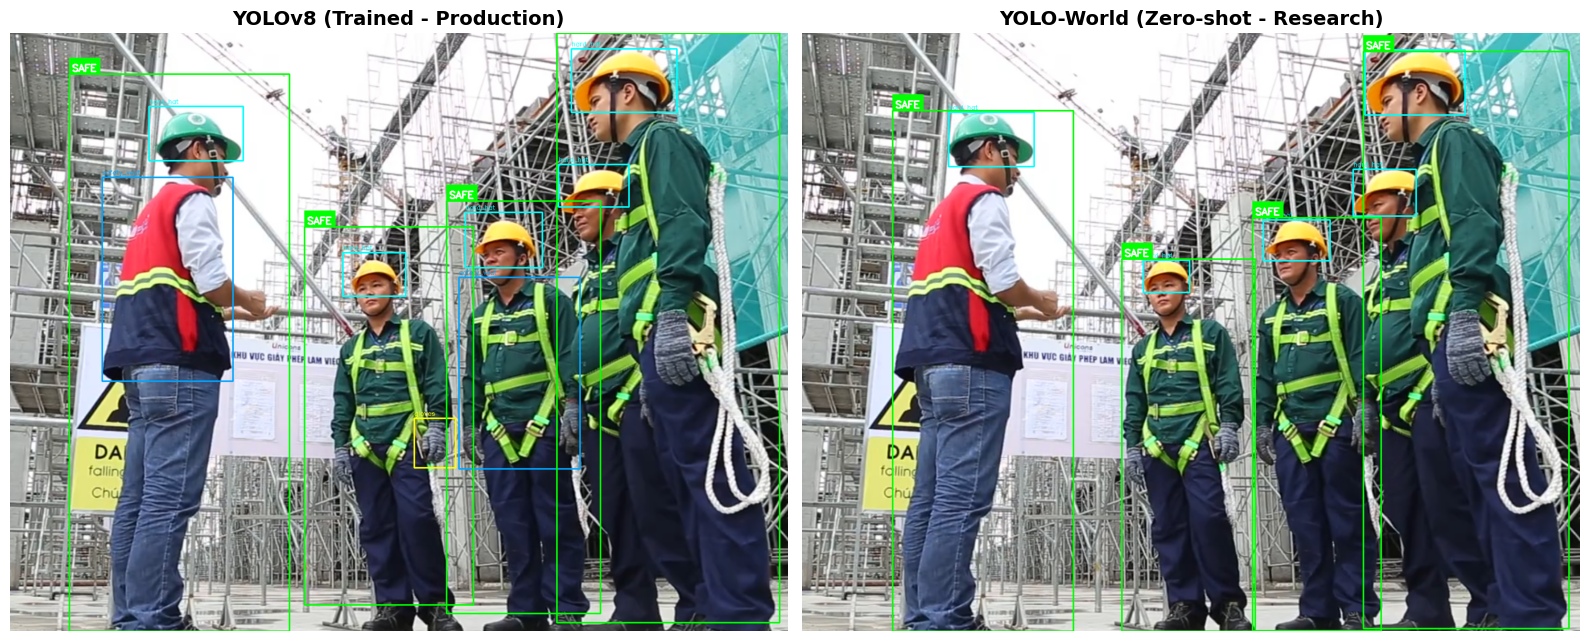

(array([[[ 87,  90,  88],
         [ 88,  90,  88],
         [ 88,  90,  88],
         ...,
         [208, 212, 144],
         [208, 212, 145],
         [211, 215, 147]],
 
        [[100, 103, 101],
         [100, 103, 101],
         [101, 103, 101],
         ...,
         [206, 210, 142],
         [209, 213, 145],
         [213, 218, 149]],
 
        [[121, 124, 122],
         [122, 124, 122],
         [122, 124, 122],
         ...,
         [204, 209, 140],
         [210, 214, 145],
         [214, 218, 150]],
 
        ...,
 
        [[206, 219, 220],
         [205, 218, 219],
         [204, 216, 218],
         ...,
         [212, 218, 216],
         [212, 219, 216],
         [211, 219, 216]],
 
        [[206, 218, 219],
         [206, 217, 218],
         [205, 216, 217],
         ...,
         [148, 152, 151],
         [149, 153, 151],
         [148, 154, 151]],
 
        [[190, 200, 201],
         [190, 200, 202],
         [191, 200, 202],
         ...,
         [147, 151, 149],
  

In [35]:
compare_models_on_image('images_test/1.png')

## 7. Xử lý Video và Real-time Monitoring

### 7.1. Demo trên video

In [30]:
def process_video_frame_by_frame(
    video_path: str,
    config_path: str,
    max_frames: int = None,
    save_output: bool = False,
    output_path: str = None
):
    """
    Xử lý video frame-by-frame với pipeline PPE detection.
    
    Args:
        video_path: Đường dẫn video hoặc camera index (0, 1, ...)
        config_path: Đường dẫn config file
        max_frames: Giới hạn số frames (None = tất cả)
        save_output: Có lưu video output không
        output_path: Đường dẫn lưu video output
    
    Returns:
        Statistics dictionary
    """
    # Load config
    config = load_config(config_path)
    
    # Khởi tạo modules
    detection_type = config.get('detection', {}).get('type', 'trained')
    
    if detection_type == 'trained':
        detector = YOLOv8Detector(
            model_path=config['detection']['model_path'],
            config=config
        )
    else:
        model_size = config['detection'].get('model_size', 's')
        model_path = f'weights/yolov8{model_size}-world.pt'
        detector = YOLOWorldDetector(model_path=model_path, config=config)
        prompts = config['ppe_rules'].get('prompts', [])
        detector.set_prompts(prompts)
    
    checker = PPEChecker(config)
    visualizer = Visualizer(config)
    logger = ViolationLogger(config)
    
    # Mở video
    if isinstance(video_path, str) and video_path.isdigit():
        video_path = int(video_path)
    
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"[ERROR] Không thể mở video: {video_path}")
        return None
    
    # Thông tin video
    fps = cap.get(cv2.CAP_PROP_FPS) or 30
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    print(f"[INFO] Video Info: {width}x{height} @ {fps:.1f} FPS, {total_frames} frames")
    
    # VideoWriter nếu cần
    writer = None
    if save_output and output_path:
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        writer = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
        print(f"[INFO] Sẽ lưu output: {output_path}")
    
    # Statistics
    stats = {
        'frame_count': 0,
        'total_persons': 0,
        'total_violations': 0,
        'violations_by_type': {}
    }
    
    # Process frames
    print("[INFO] Bắt đầu xử lý video...")
    try:
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            
            stats['frame_count'] += 1
            
            # Detection
            results = detector.predict(
                frame,
                conf_threshold=config['detection']['confidence_threshold'],
                iou_threshold=config['detection'].get('iou_threshold', 0.45)
            )
            detections = detector.get_detections(results)
            persons = detections.get('person', [])  
            equipment = {k: v for k, v in detections.items() if k != 'person'}
            
            # Compliance check
            compliance_results = checker.check_compliance(persons, equipment)
            
            # Log violations
            for result in compliance_results:
                if not result.is_compliant:
                    logger.log_violation(frame, result, datetime.now())
                    stats['total_violations'] += 1
                    for eq in result.missing_equipment:
                        stats['violations_by_type'][eq] = stats['violations_by_type'].get(eq, 0) + 1
            
            stats['total_persons'] += len(persons)
            
            # Visualize
            annotated_frame = visualizer.draw_results(frame, compliance_results, equipment)
            
            # Draw stats
            frame_stats = {
                'frame_number': stats['frame_count'],
                'total_persons': stats['total_persons'],
                'total_violations': stats['total_violations']
            }
            display_frame = visualizer.draw_statistics(annotated_frame, frame_stats, None)
            
            # Save frame
            if writer:
                writer.write(display_frame)
            
            # Progress
            if stats['frame_count'] % 30 == 0:
                print(f"  Frame {stats['frame_count']}/{total_frames} | "
                      f"Persons: {len(persons)} | Violations: {sum(1 for r in compliance_results if not r.is_compliant)}")
            
            # Max frames limit
            if max_frames and stats['frame_count'] >= max_frames:
                break
                
    finally:
        cap.release()
        if writer:
            writer.release()
            print(f"[INFO] Đã lưu video: {output_path}")
    
    print("\n" + "=" * 70)
    print("THỐNG KÊ XỬ LÝ VIDEO")
    print("=" * 70)
    print(f"Tổng frames: {stats['frame_count']}")
    print(f"Tổng persons: {stats['total_persons']}")
    print(f"Tổng violations: {stats['total_violations']}")
    if stats['total_persons'] > 0:
        violation_rate = (stats['total_violations'] / stats['total_persons']) * 100
        print(f"Tỷ lệ violation: {violation_rate:.1f}%")
    print("=" * 70)
    
    return stats


print("[INFO] Hàm process_video_frame_by_frame đã sẵn sàng")
print("[INFO] Sử dụng:")
print("  stats = process_video_frame_by_frame(")
print("      video_path='videos_test/bao-ho-lao-dong.mp4',")
print("      config_path='config/config_yolov8_production.yaml',")
print("      max_frames=100,  # Giới hạn để test")
print("      save_output=True,")
print("      output_path='output/demo_video.mp4'")
print("  )")

[INFO] Hàm process_video_frame_by_frame đã sẵn sàng
[INFO] Sử dụng:
  stats = process_video_frame_by_frame(
      video_path='videos_test/bao-ho-lao-dong.mp4',
      config_path='config/config_yolov8_production.yaml',
      max_frames=100,  # Giới hạn để test
      save_output=True,
      output_path='output/demo_video.mp4'
  )


## 8. Phân tích Violations

### 8.1. Đọc và phân tích log violations

[INFO] Phân tích violations log: c:\Workspaces\IUH\semantic_surveillance\data\violations\violations.jsonl

Tổng số violations: 3144

Violations theo loại:
  - hard_hat: 3051
  - safety_vest: 997


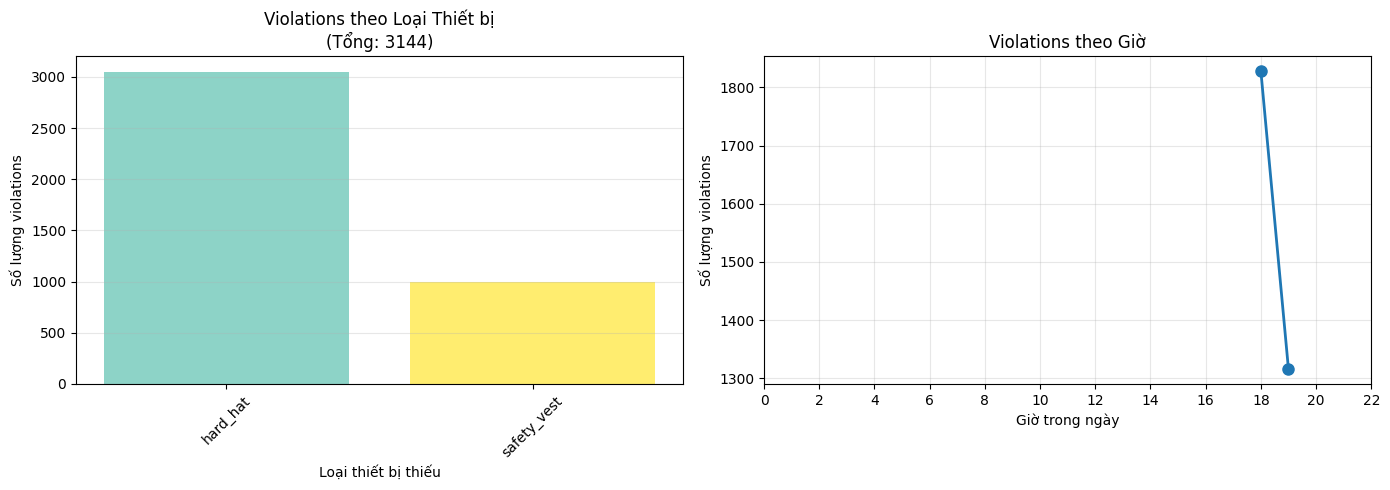

In [31]:
def analyze_violations_log(log_file: str = None):
    """
    Phân tích log violations từ file JSONL.
    
    Args:
        log_file: Đường dẫn file violations.jsonl (None = tự động tìm)
    
    Returns:
        Statistics dictionary
    """
    if log_file is None:
        log_file = project_root / "data" / "violations" / "violations.jsonl"
    else:
        log_file = Path(log_file)
    
    if not log_file.exists():
        print(f"[INFO] Không tìm thấy log file: {log_file}")
        return None
    
    violations = []
    violations_by_type = {}
    violations_by_hour = {}
    
    with open(log_file, 'r', encoding='utf-8') as f:
        for line in f:
            try:
                data = json.loads(line)
                violations.append(data)
                
                # Count by type
                for eq in data.get('missing_equipment', []):
                    violations_by_type[eq] = violations_by_type.get(eq, 0) + 1
                
                # Count by hour
                timestamp = datetime.fromisoformat(data['timestamp'])
                hour = timestamp.hour
                violations_by_hour[hour] = violations_by_hour.get(hour, 0) + 1
            except:
                continue
    
    stats = {
        'total_violations': len(violations),
        'violations_by_type': violations_by_type,
        'violations_by_hour': violations_by_hour,
        'violations': violations
    }
    
    return stats


def plot_violation_statistics(stats: Dict):
    """Vẽ biểu đồ thống kê violations"""
    if stats is None:
        print("[WARNING] Không có dữ liệu")
        return
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Biểu đồ violations theo type
    types = list(stats['violations_by_type'].keys())
    counts = [stats['violations_by_type'][t] for t in types]
    
    if types:
        axes[0].bar(types, counts, color=plt.cm.Set3(np.linspace(0, 1, len(types))))
        axes[0].set_xlabel('Loại thiết bị thiếu')
        axes[0].set_ylabel('Số lượng violations')
        axes[0].set_title(f'Violations theo Loại Thiết bị\n(Tổng: {stats["total_violations"]})')
        axes[0].tick_params(axis='x', rotation=45)
        axes[0].grid(axis='y', alpha=0.3)
    
    # Biểu đồ violations theo giờ
    hours = sorted(stats['violations_by_hour'].keys())
    hour_counts = [stats['violations_by_hour'][h] for h in hours]
    
    if hours:
        axes[1].plot(hours, hour_counts, marker='o', linewidth=2, markersize=8)
        axes[1].set_xlabel('Giờ trong ngày')
        axes[1].set_ylabel('Số lượng violations')
        axes[1].set_title('Violations theo Giờ')
        axes[1].grid(alpha=0.3)
        axes[1].set_xticks(range(0, 24, 2))
    
    plt.tight_layout()
    return fig


# Phân tích violations log
violations_log = project_root / "data" / "violations" / "violations.jsonl"

if violations_log.exists():
    print(f"[INFO] Phân tích violations log: {violations_log}")
    violation_stats = analyze_violations_log(str(violations_log))
    
    if violation_stats:
        print(f"\nTổng số violations: {violation_stats['total_violations']}")
        print("\nViolations theo loại:")
        for eq_type, count in violation_stats['violations_by_type'].items():
            print(f"  - {eq_type}: {count}")
        
        # Vẽ biểu đồ
        plot_violation_statistics(violation_stats)
        plt.show()
else:
    print(f"[INFO] Chưa có violations log tại: {violations_log}")
    print("[INFO] Log sẽ được tạo tự động khi chạy inference và phát hiện violations")

## 9. Tổng kết và Kết luận

### 9.1. Tóm tắt Pipeline End-to-End

Quy trình hoàn chỉnh từ dữ liệu đến deployment:

1. **Data Preparation**: Chuẩn bị dataset với format YOLO
2. **Labeling**: Gán nhãn cho các objects (person, helmet, vest, etc.)
3. **Data Visualization**: Phân tích và trực quan hóa dữ liệu
4. **Model Training**: Huấn luyện YOLOv8 trên dataset
5. **Model Evaluation**: Đánh giá mô hình trên validation set
6. **Inference**: Sử dụng mô hình để detect PPE trên ảnh/video
7. **Compliance Checking**: Kiểm tra tuân thủ quy tắc an toàn
8. **Violation Logging**: Ghi log các violations để phân tích

### 9.2. So sánh hai chế độ

| Đặc điểm | YOLOv8 (Trained) | YOLO-World (Zero-shot) |
|----------|------------------|------------------------|
| **Độ chính xác** | Cao (fine-tuned) | Trung bình-Cao |
| **Tốc độ** | Nhanh | Nhanh |
| **Cần training** | Có | Không |
| **Cần labeling** | Có | Không |
| **Flexibility** | Thấp (cố định classes) | Cao (text prompts) |
| **Use case** | Production | Research/Prototyping |

### 9.3. Hướng phát triển

- Tối ưu hóa tốc độ inference
- Mở rộng dataset với nhiều điều kiện ánh sáng/weather
- Tích hợp tracking để theo dõi người qua nhiều frames
- Xây dựng dashboard real-time
- Deploy lên edge devices (Jetson, Raspberry Pi)

In [32]:
print("=" * 70)
print("NOTEBOOK END-TO-END PIPELINE HOÀN TẤT")
print("=" * 70)
print("\nCác chức năng đã được định nghĩa:")
print("  1. check_dataset_structure() - Kiểm tra cấu trúc dataset")
print("  2. visualize_yolo_labels() - Hiển thị nhãn YOLO")
print("  3. analyze_dataset_statistics() - Phân tích thống kê dataset")
print("  4. train_ppe_model() - Huấn luyện mô hình")
print("  5. evaluate_model() - Đánh giá mô hình")
print("  6. demo_inference_on_image() - Inference trên ảnh")
print("  7. compare_models_on_image() - So sánh 2 mô hình")
print("  8. process_video_frame_by_frame() - Xử lý video")
print("  9. analyze_violations_log() - Phân tích violations")
print("\nSử dụng các hàm trên để thực hiện pipeline end-to-end!")
print("=" * 70)

NOTEBOOK END-TO-END PIPELINE HOÀN TẤT

Các chức năng đã được định nghĩa:
  1. check_dataset_structure() - Kiểm tra cấu trúc dataset
  2. visualize_yolo_labels() - Hiển thị nhãn YOLO
  3. analyze_dataset_statistics() - Phân tích thống kê dataset
  4. train_ppe_model() - Huấn luyện mô hình
  5. evaluate_model() - Đánh giá mô hình
  6. demo_inference_on_image() - Inference trên ảnh
  7. compare_models_on_image() - So sánh 2 mô hình
  8. process_video_frame_by_frame() - Xử lý video
  9. analyze_violations_log() - Phân tích violations

Sử dụng các hàm trên để thực hiện pipeline end-to-end!


Có thể đọc file README.md để hiểu rõ hơn về cách sử dụng pipeline này cũng như toàn bộ dự án. Dự án được public trên Github tại: https://github.com/ti014/semantic_surveillance.git